In [7]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [13]:
#State Variable

x = np.array([0, 1., 0., 0.5]) # Initial state (px, vx, py, vy)

#Initialising covariances to zero because I'm assuming that everything is independent of each other at the start
P = np.diag([0.01, 0.1, 0.01, 0.1])  # Initial covariance matrix

dt = 1  # Time step (in seconds)

F = np.array([[1, dt, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, dt], 
              [0, 0, 0, 1]])  # Constant Velocity Model

sigma_acc = 0.1  # Standard deviation of the acceleration (m/s^2);
q = sigma_acc**2
Q = np.array([[dt**4/4, dt**3/2, 0, 0],
                [dt**3/2, dt**2, 0, 0], 
                [0, 0, dt**4/4, dt**3/2], 
                [0, 0, dt**3/2, dt**2]]) * q

H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])  # Measurement matrix (we only measure position)



Chose the position of the car to start at the origin and the car to have a velocity of ($1ms^{-1}$, $0.5ms^{-1}$), because they were simple values.

Then for my Covariance matrix I chose small values because I'm deciding that initially I'm very sure about its position and I'm very sure about its velocity just not quite as sure as I am position.

For the Process Model, F, in our constant velocity model the position is given to us by $\bar{x} = x + \dot{x} \Delta t$, where $\bar{x}$ is our state estimate, and $\dot{x}$ is the derivate of the position, i.e. the velocity. And because velocity is constant we have $\dot{x}$ = $\dot{x}$. So we have $$\bar{x}_k = 1 \cdot x_{k-1} + \Delta t\,\dot{x_{k-1}}$$ and  $$\bar{\dot{x}} = 0 \cdot x_{k - 1} + 1 \cdot \dot{x_{k-1}}$$ this gives us our matrix form. $$\begin{bmatrix} \bar{x} \\ \bar{\dot{x}} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x_{k-1} \\ \dot{x_{k-1}} \end{bmatrix}$$ $$ \bar{x} = Fx $$


Q is the noise covariance matrix, this will be our acceleration noise that the constant velocity model isn’t entirely accurate about. We know

$$x_{k+1} = x_k + v_k\Delta t + \tfrac{1}{2} a_k (\Delta t)^2$$
and
$$\dot{x}_{k+1} = \dot{x}_k + a_k \Delta t$$

We assume $a_k \sim \mathcal{N}(0, \sigma_{\text{acc}}^2)$, so the noise vector thus become
$\begin{bmatrix} \tfrac{1}{2} a_k (\Delta t)^2 \\ a_k \Delta t \end{bmatrix}$.

Multiplying by its transpose we then get
$a_k^2 \cdot \begin{bmatrix} \tfrac{1}{4} (\Delta t)^4 & \tfrac{1}{2} (\Delta t)^3 \\ \tfrac{1}{2} (\Delta t)^3 & (\Delta t)^2 \end{bmatrix}$.

Now because $a$ is a random variable, $a^2$ is also random, to make this covariance matrix useful we then take the expectation of $a^2$ which turns out to be $\sigma_{\text{acc}}^2$, which we can work out using our equation for working out the variance. Giving us the final noise covariance matrix. I'm assuming that both x velocity and y velocity have the same variance.

<!-- Need to decide how I'll choose sigma_acc -->

For H we want to be able to calculate residuals so in order to compare our estimation with our measurements I make sure to use a matrix that outputs both the x and y position.



In [21]:
#Kalman Filter Functions

def predict(x, P, F, Q):
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

def update(x_pred, P_pred, z, H, R):
    y = z - H @ x_pred  # Measurement residual
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x_upd = x_pred + K @ y
    I = np.eye(P_pred.shape[0])
    P_upd = (I - K @ H) @ P_pred
    return x_upd, P_upd, y, S

In [78]:
#Implementation of Kalman Filter
def kalman_filter(true_states, x, P, F, Q, H, R):
    x = x.copy()
    P = P.copy()

    true_positions = []
    measurements = []
    estimates = []
    covariances = []
    predictions = []
    prediction_covariances = []
    nis_log = []
    S_trace_log = []
    S_model_trace_log = []


    for k in range(len(true_states)):
        true_state = true_states[k]         
        true_pos = H @ true_state

        noise_std = np.sqrt(R[0,0])
        z = true_pos + np.random.normal(0, noise_std, size=2)

        x_pred, P_pred = predict(x, P, F, Q)
        predictions.append(x_pred)
        prediction_covariances.append(P_pred)
        x, P, y, S = update(x_pred, P_pred, z, H, R)
        S_model_trace_log.append(np.trace(H @ P_pred @ H.T))
        S_trace_log.append(np.trace(S))

        y = np.atleast_2d(y).reshape(-1, 1)

        nis = (y.T @ np.linalg.solve(S, y)).item()
        nis_log.append(nis)


        true_positions.append(true_pos)
        measurements.append(z)
        estimates.append([x[0], x[2]])
        covariances.append(P)

    return np.array(true_positions), np.array(measurements), np.array(estimates), np.array(covariances), np.array(predictions), np.array(prediction_covariances), np.array(nis_log), np.array(S_trace_log), np.array(S_model_trace_log)

In [79]:
#Plotting Function
def plot_results(true_positions, measurements, estimates):
    time_idx = np.arange(len(measurements))        # 0, 1, 2, ..., N-1

    plt.figure(figsize=(10, 6))

    # 1. True trajectory (car following constant velocity)
    plt.plot(true_positions[:, 0], true_positions[:, 1],
            label="True Position", linewidth=2)

    # 2. Measurements, colour = time step
    sc = plt.scatter(measurements[:, 0], measurements[:, 1],
                    c=time_idx,
                    cmap="viridis",      # try 'plasma' or 'inferno' if you prefer
                    s=15,
                    alpha=0.9,
                    label="Measurements")

    cbar = plt.colorbar(sc)
    cbar.set_label("Time step")

    # 3. Kalman Filter estimate
    plt.plot(estimates[:, 0], estimates[:, 1],
            label="KF Estimate", linewidth=2)

    plt.title("Kalman Filter Position Tracking")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.autoscale()
    plt.grid(True)
    plt.legend()
    plt.show()

In [80]:
def constant_velocity_true_position(num_steps, dt, v_x, v_y):
    true_states = []

    for k in range(num_steps):
        t = k * dt
        px = v_x * t
        py = v_y * t
        true_state = np.array([px, v_x, py, v_y])
        true_states.append(true_state)

    return np.array(true_states)

In [89]:
def run_scenario_constant_velocity(name, x0, P0, F, Q, H, R, num_steps=50, v_x=1.0, v_y=0.5):
    """
    Runs the existing kalman_filter with given parameters
    and plots the trajectories.
    """
    print(f"\n=== Scenario: {name} ===")

    # Generate truth
    true_states = constant_velocity_true_position(num_steps, dt, v_x, v_y)

    # Run your existing KF
    true_positions, measurements, estimates, covariances, predictions, prediction_covariances, nis_log, S_trace_log, S_model_trace_log = kalman_filter(
        true_states=true_states,
        x=x0,
        P=P0,
        F=F,
        Q=Q,
        H=H,
        R=R,
    )

    # Plot (no ellipses, just your original plot)
    plot_results(true_positions, measurements, estimates)

    print("Mean NIS:", np.mean(nis_log))
    print("Expected ~ measurement dim:", H.shape[0])

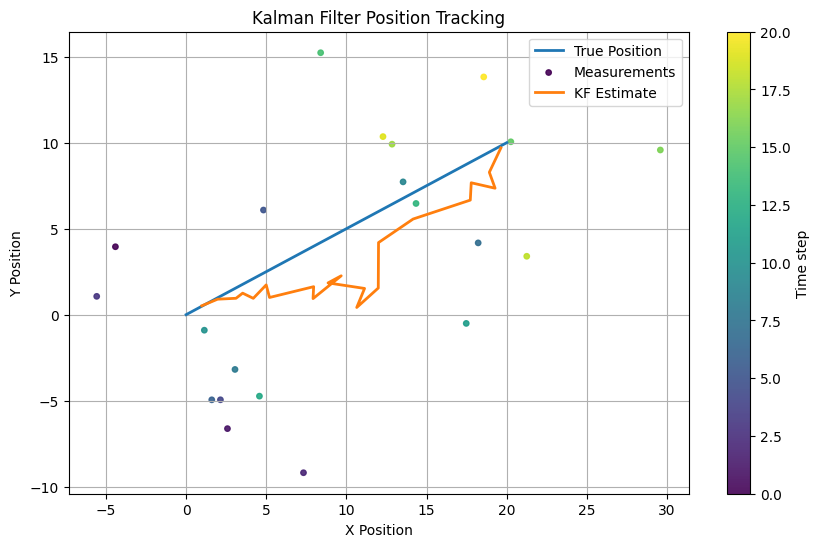

Mean NIS: 2.8278481881377426
Expected ~ measurement dim: 2
Mean NIS (all): 2.8278481881377426
Mean NIS (post burn-in): 2.7571501649721695
Empirical measurement variance: [38.64304712 28.53306699]
R diagonal: [25 25]
mean trace(H P_pred H^T): 8.77852748655887
mean trace(S): 58.77852748655886
trace(R): 50


In [82]:
#Now we run and plot the results
true_states = constant_velocity_true_position(21, dt, 1.0, 0.5)

R = np.diag([25, 25])

true_positions, measurements, estimates, covariances, predictions, prediction_covariances, nis_log, S_trace_log, S_model_trace_log = kalman_filter(x=x, P=P, F=F, Q=Q, H=H, R=R, true_states = true_states)

plot_results(true_positions, measurements, estimates)

print("Mean NIS:", np.mean(nis_log))
print("Expected ~ measurement dim:", H.shape[0])

cut = int(0.2 * len(nis_log))

print("Mean NIS (all):", np.mean(nis_log))
print("Mean NIS (post burn-in):", np.mean(nis_log[cut:]))

v = measurements - true_positions

print("Empirical measurement variance:", np.var(v, axis=0))
print("R diagonal:", np.diag(R))

print("mean trace(H P_pred H^T):", np.mean(S_model_trace_log))
print("mean trace(S):", np.mean(S_trace_log))
print("trace(R):", np.trace(R))

Maybe too much noise for this graph as dt is only 1 second. Vx and vy are 1 and 0.5 respectively, meaning that after each time step the car moves around 1 meter in x axis and half a meter in the y axis after a time step, but my measurement noise makes my readings accurate to ±5 meters which is much larger.

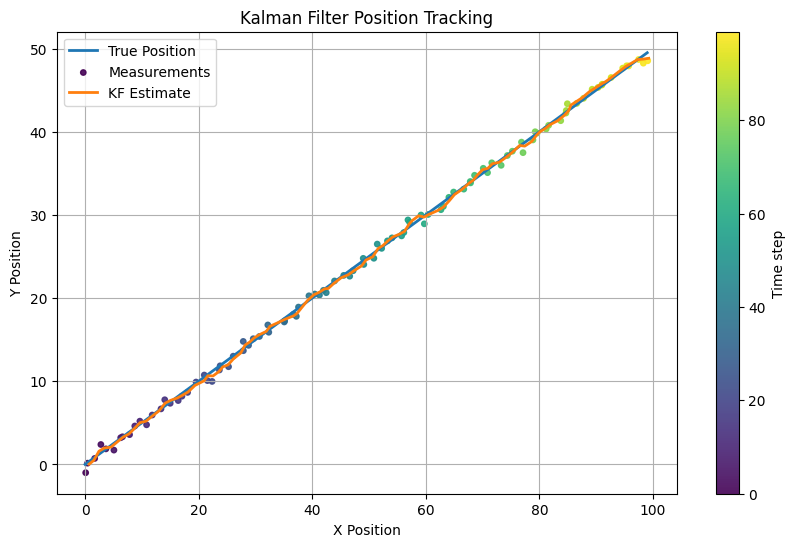

Mean NIS: 1.5187146038069659
Expected ~ measurement dim: 2
Mean NIS (all): 1.5187146038069659
Mean NIS (post burn-in): 1.4841572785805002
Empirical measurement variance: [0.22768253 0.19755384]
R diagonal: [0.25 0.25]
mean trace(H P_pred H^T): 0.4418743201069877
mean trace(S): 0.9418743201069876
trace(R): 0.5


In [83]:
R = np.diag([0.25, 0.25])
true_states = constant_velocity_true_position(100, dt, 1.0, 0.5)

true_positions, measurements, estimates, covariances, predictions, prediction_covariances, nis_log, S_trace_log, S_model_trace_log = kalman_filter(true_states, x, P, F, Q, H, R)

plot_results(true_positions, measurements, estimates)

print("Mean NIS:", np.mean(nis_log))
print("Expected ~ measurement dim:", H.shape[0])

cut = int(0.2 * len(nis_log))

print("Mean NIS (all):", np.mean(nis_log))
print("Mean NIS (post burn-in):", np.mean(nis_log[cut:]))

v = measurements - true_positions

print("Empirical measurement variance:", np.var(v, axis=0))
print("R diagonal:", np.diag(R))

print("mean trace(H P_pred H^T):", np.mean(S_model_trace_log))
print("mean trace(S):", np.mean(S_trace_log))
print("trace(R):", np.trace(R))

That's more like it.

And for my next trick, I'll be using measurements that don't quite follow the constant velocity model that I have assumed.

In [84]:
def quadratic_true_position(num_steps, dt, v0_x, k_y):
    true_states = []

    t = 0.0
    for _ in range(num_steps):
        t += dt

        px = v0_x * t
        vx = v0_x

        py = k_y * (t ** 2)
        vy = 2 * k_y * t       

        true_states.append(np.array([px, vx, py, vy]))

    return np.array(true_states)

In [90]:
def run_scenario_quadratic(name, x0, P0, F, Q, H, R, num_steps=50, v_x=1.0, v_y=0.5):
    """
    Runs the existing kalman_filter with given parameters
    and plots the trajectories.
    """
    print(f"\n=== Scenario: {name} ===")

    # Generate truth
    true_states = quadratic_true_position(num_steps, dt, v_x, v_y)

    # Run your existing KF
    true_positions, measurements, estimates, covariances, predictions, prediction_covariances, nis_log, S_trace_log, S_model_trace_log = kalman_filter(
        true_states=true_states,
        x=x0,
        P=P0,
        F=F,
        Q=Q,
        H=H,
        R=R,
    )

    # Plot (no ellipses, just your original plot)
    plot_results(true_positions, measurements, estimates)

    print("Mean NIS:", np.mean(nis_log))
    print("Expected ~ measurement dim:", H.shape[0])

    cut = int(0.2 * len(nis_log))

    print("Mean NIS (all):", np.mean(nis_log))
    print("Mean NIS (post burn-in):", np.mean(nis_log[cut:]))

    v = measurements - true_positions

    print("Empirical measurement variance:", np.var(v, axis=0))
    print("R diagonal:", np.diag(R))

    print("Mean trace(S):", np.mean(S_trace_log))
    print("Trace(R):", np.trace(R))

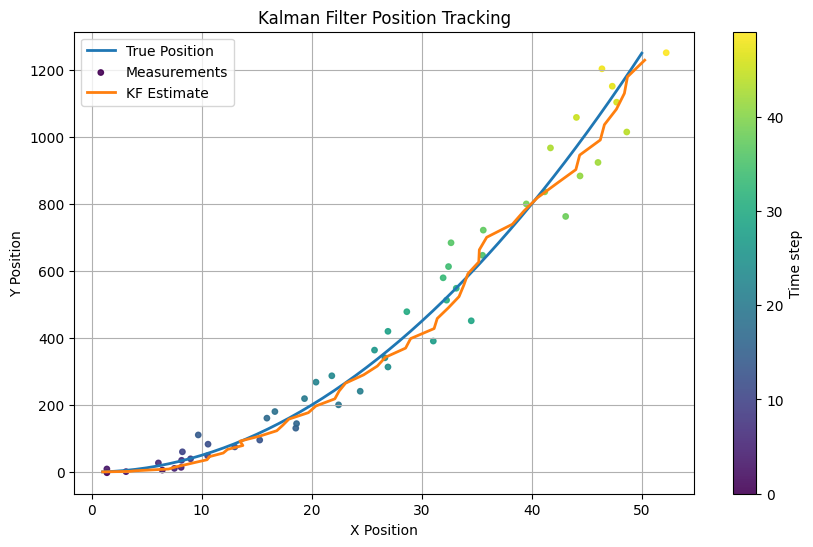

Mean NIS: 83.23013290753009
Expected ~ measurement dim: 2
Mean NIS (all): 83.23013290753009
Mean NIS (post burn-in): 100.21474488515537
Empirical measurement variance: [5.5337271  4.70673205]
R diagonal: [6.25 6.25]
Mean trace(S): 16.408597416601197
Trace(R): 12.5


In [87]:
R = np.diag([6.25, 6.25]) #95% of measurements within ±5m of the true data.

true_states = quadratic_true_position(50, dt, 1.0, 0.5)

true_positions, measurements, estimates, covariances, predictions, prediction_covariances, nis_log, S_trace_log, S_model_trace_log = kalman_filter(true_states, x, P, F, Q, H, R)

plot_results(true_positions, measurements, estimates)

print("Mean NIS:", np.mean(nis_log))
print("Expected ~ measurement dim:", H.shape[0])

cut = int(0.2 * len(nis_log))

print("Mean NIS (all):", np.mean(nis_log))
print("Mean NIS (post burn-in):", np.mean(nis_log[cut:]))

v = measurements - true_positions

print("Empirical measurement variance:", np.var(v, axis=0))
print("R diagonal:", np.diag(R))

print("Mean trace(S):", np.mean(S_trace_log))
print("Trace(R):", np.trace(R))

In [ ]:
def plot_covariance_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    mean: length-2 array [px, py]
    cov:  2x2 covariance matrix for position
    ax:   matplotlib Axes to draw on
    n_std: how many standard deviations (2 ≈ 95%)
    kwargs: passed to Ellipse (edgecolor, facecolor, alpha, etc)
    """
    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)

    # Sort largest to smallest
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Angle of ellipse (in degrees)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # Width and height: 2 * n_std * sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(vals)

    ell = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        fill=False,
        **kwargs
    )
    ax.add_patch(ell)

In [ ]:
def plot_results_with_ellipses(true_positions, measurements,
                               estimates, covariances,
                               predictions, prediction_covariances,
                               step=1):
    """
    For a *small* window of timesteps.
    Shows:
      - true positions
      - measurements
      - prediction ellipses + means
      - update ellipses + means
      - arrows from prediction mean -> update mean
    """

    def pos_cov(P):
        """Return 2x2 position covariance from P."""
        P = np.asarray(P)
        if P.shape == (4, 4):
            # full state [x, vx, y, vy] -> take (x,y) block
            return P[[0, 2]][:, [0, 2]]
        elif P.shape == (2, 2):
            return P
        else:
            raise ValueError(f"Unexpected covariance shape: {P.shape}")

    time_idx = np.arange(len(measurements))
    fig, ax = plt.subplots(figsize=(8, 6))

    # 1. True trajectory (only for this small window)
    ax.plot(true_positions[:, 0], true_positions[:, 1],
            label="True Position", linewidth=2)

    # 2. Measurements (coloured by time in this window)
    sc = ax.scatter(measurements[:, 0], measurements[:, 1],
                    c=time_idx,
                    cmap="viridis",
                    s=40,
                    alpha=0.9,
                    label="Measurements")
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("Time step (window index)")

    # For zooming later
    xs_all, ys_all = [], []

    # 3. Ellipses + means for each chosen step
    for k in range(0, len(estimates), step):
        # ----- Updated (posterior) -----
        mean_upd = np.asarray(estimates[k])          # [x, y]
        P_pos_upd = pos_cov(covariances[k])

        plot_covariance_ellipse(
            mean_upd, P_pos_upd, ax,
            n_std=2.0,
            edgecolor='red',
            alpha=0.5,
            linewidth=1,
        )

        # Mark updated mean as red circle
        ax.scatter(mean_upd[0], mean_upd[1],
                   edgecolors='red', facecolors='none',
                   s=80,
                   label="Updated mean" if k == 0 else None)

        # ----- Predicted (prior) -----
        mean_pred = np.asarray(predictions[k])       # [x, y]
        P_pos_pred = pos_cov(prediction_covariances[k])

        plot_covariance_ellipse(
            mean_pred, P_pos_pred, ax,
            n_std=2.0,
            edgecolor='orange',
            linestyle='--',
            alpha=0.8,
            linewidth=1,
        )

        # Mark prediction mean as orange X
        ax.scatter(mean_pred[0], mean_pred[1],
                   color='orange',
                   marker='x',
                   s=80,
                   label="Prediction mean" if k == 0 else None)

        # Arrow from prediction mean -> updated mean
        ax.annotate(
            "",
            xy=(mean_upd[0], mean_upd[1]),
            xytext=(mean_pred[0], mean_pred[1]),
            arrowprops=dict(arrowstyle="->", color="grey", lw=1)
        )

        # Collect for zoom
        xs_all.extend([mean_upd[0], mean_pred[0], measurements[k, 0]])
        ys_all.extend([mean_upd[1], mean_pred[1], measurements[k, 1]])

    # 4. Zoom around this little cluster so shapes are clear
    xs_all = np.array(xs_all)
    ys_all = np.array(ys_all)
    pad = 2
    ax.set_xlim(xs_all.min() - pad, xs_all.max() + pad)
    ax.set_ylim(ys_all.min() - pad, ys_all.max() + pad)

    ax.set_title("Prediction vs Update Uncertainty (per step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()
    plt.show()

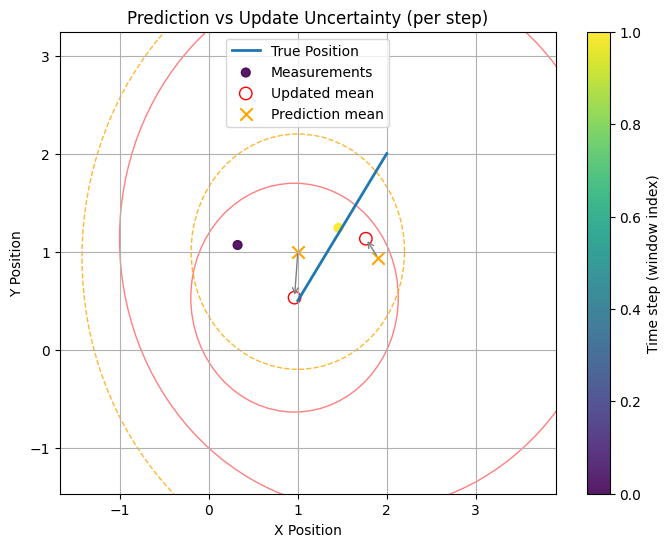

In [ ]:
# Choose a short window
idx = np.arange(0, 2)

true_small = true_positions[idx]
meas_small = measurements[idx]
est_small = estimates[idx]
cov_small = covariances[idx]
pred_small = predictions[idx]
pred_cov_small = prediction_covariances[idx]

# Now plot ellipses for *each* of these (only 4 timesteps)
plot_results_with_ellipses(
    true_small,
    meas_small,
    est_small,
    cov_small,
    pred_small,
    pred_cov_small,
    step=1,          # every point in this tiny window
)


=== Scenario: R LOW (trust measurements a lot) ===


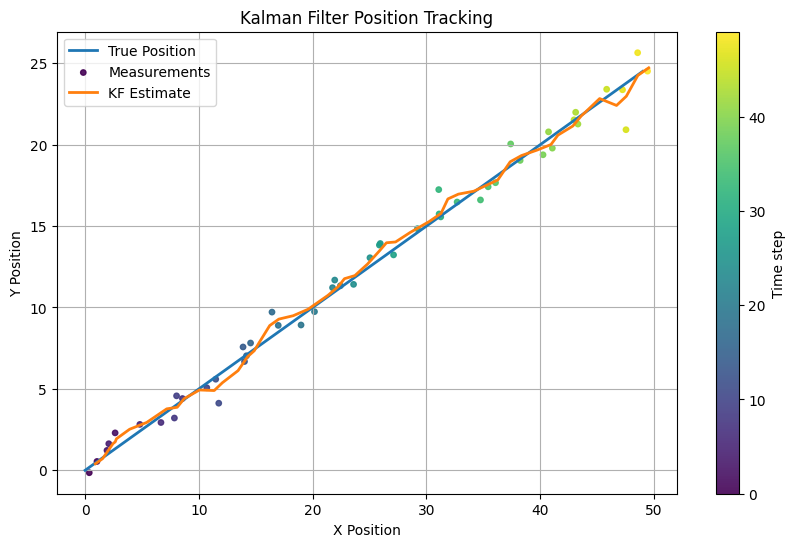

Mean NIS: 1.7056931984134525
Expected ~ measurement dim: 2

=== Scenario: R BASELINE ===


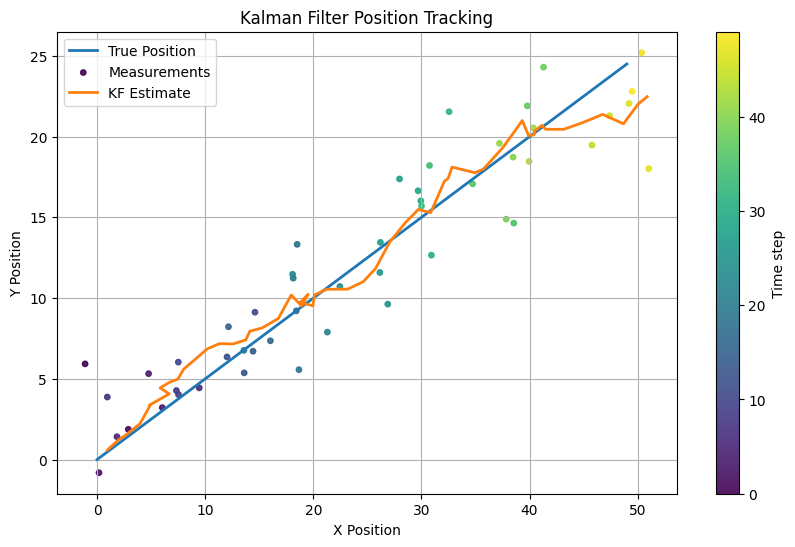

Mean NIS: 1.8710828488533704
Expected ~ measurement dim: 2

=== Scenario: R HIGH (measurements very noisy) ===


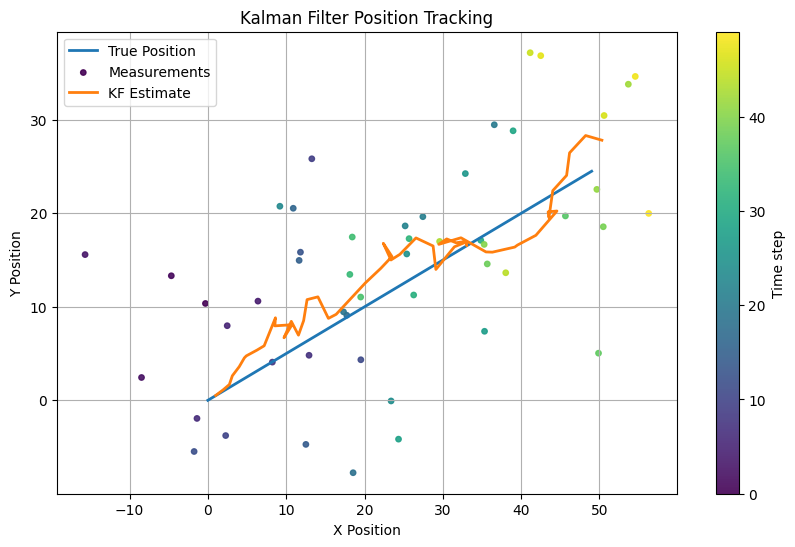

Mean NIS: 2.542085418670958
Expected ~ measurement dim: 2

=== Scenario: R LOW (trust measurements a lot) ===


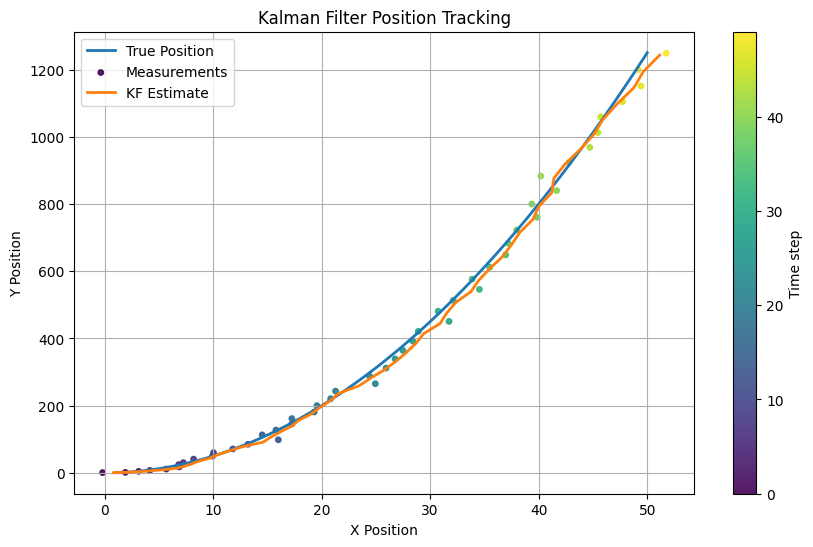

Mean NIS: 90.48789000774318
Expected ~ measurement dim: 2
Mean NIS (all): 90.48789000774318
Mean NIS (post burn-in): 102.61980790213181
Empirical measurement variance: [0.64205659 0.61270123]
R diagonal: [0.625 0.625]
Mean trace(S): 2.066812608129457
Trace(R): 1.25

=== Scenario: R BASELINE ===


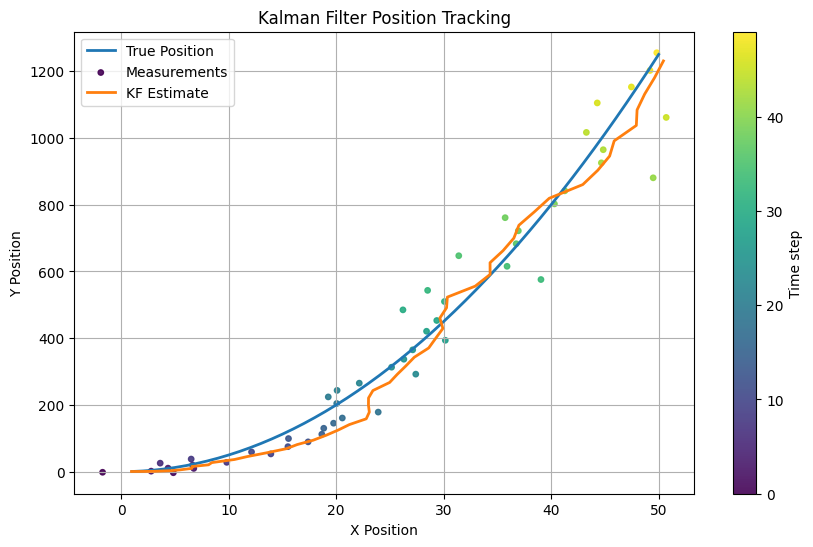

Mean NIS: 84.14558725289695
Expected ~ measurement dim: 2
Mean NIS (all): 84.14558725289695
Mean NIS (post burn-in): 101.0022055656929
Empirical measurement variance: [7.30143854 5.976396  ]
R diagonal: [6.25 6.25]
Mean trace(S): 16.408597416601197
Trace(R): 12.5

=== Scenario: R HIGH (measurements very noisy) ===


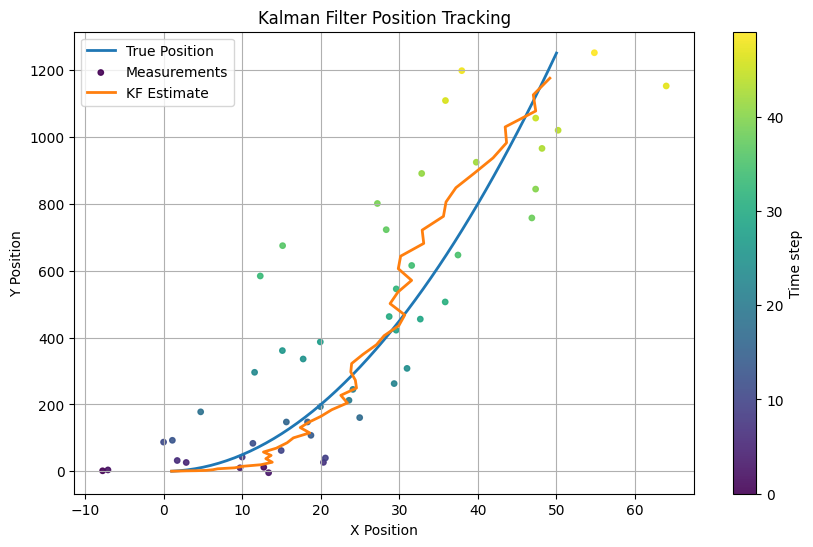

Mean NIS: 68.71459856380477
Expected ~ measurement dim: 2
Mean NIS (all): 68.71459856380477
Mean NIS (post burn-in): 84.4316899846679
Empirical measurement variance: [74.33299401 43.41729985]
R diagonal: [62.5 62.5]
Mean trace(S): 143.6442090834258
Trace(R): 125.0


In [91]:
# Baseline parameters
R_base = np.diag([6.25, 6.25])   # whatever you currently use
Q_base = Q
P0_base = P
x0_base = x

# Low, medium, high measurement noise
R_low  = 0.1 * R_base
R_med  = R_base
R_high = 10.0 * R_base

run_scenario_constant_velocity("R LOW (trust measurements a lot)", x0_base, P0_base, F, Q_base, H, R_low)
run_scenario_constant_velocity("R BASELINE",                      x0_base, P0_base, F, Q_base, H, R_med)
run_scenario_constant_velocity("R HIGH (measurements very noisy)",x0_base, P0_base, F, Q_base, H, R_high)
run_scenario_quadratic("R LOW (trust measurements a lot)", x0_base, P0_base, F, Q_base, H, R_low)
run_scenario_quadratic("R BASELINE", x0_base, P0_base, F, Q_base, H, R_med)
run_scenario_quadratic("R HIGH (measurements very noisy)", x0_base, P0_base, F, Q_base, H, R_high)


=== Scenario: Q LOW (trust motion model) ===


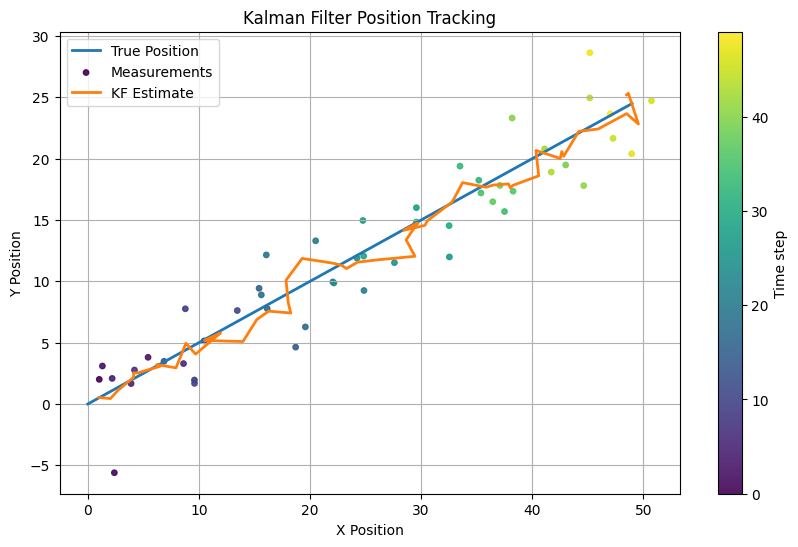

Mean NIS: 1.6948147561398788
Expected ~ measurement dim: 2

=== Scenario: Q BASELINE ===


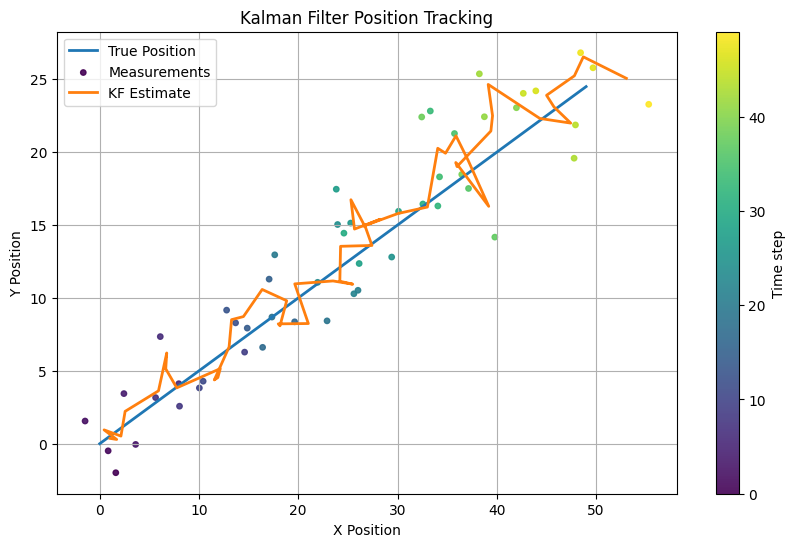

Mean NIS: 1.5756031415347778
Expected ~ measurement dim: 2

=== Scenario: Q HIGH (motion very uncertain) ===


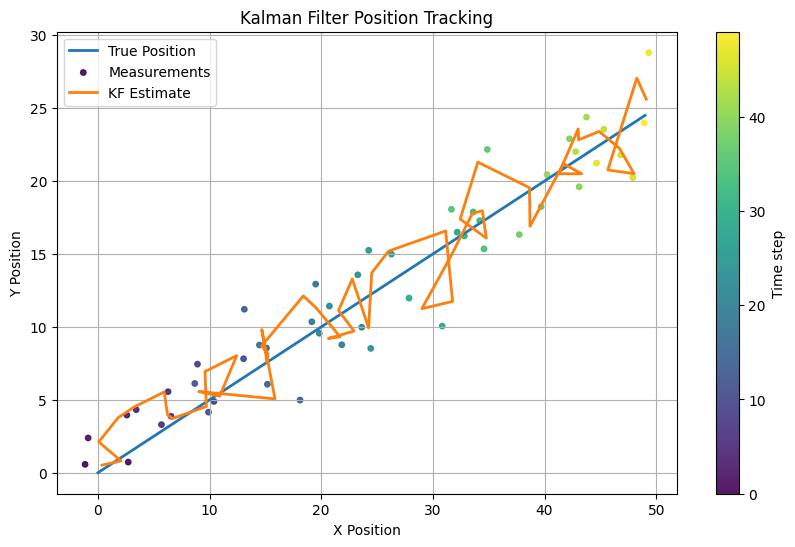

Mean NIS: 0.9548285499299071
Expected ~ measurement dim: 2

=== Scenario: Q LOW (trust motion model) ===


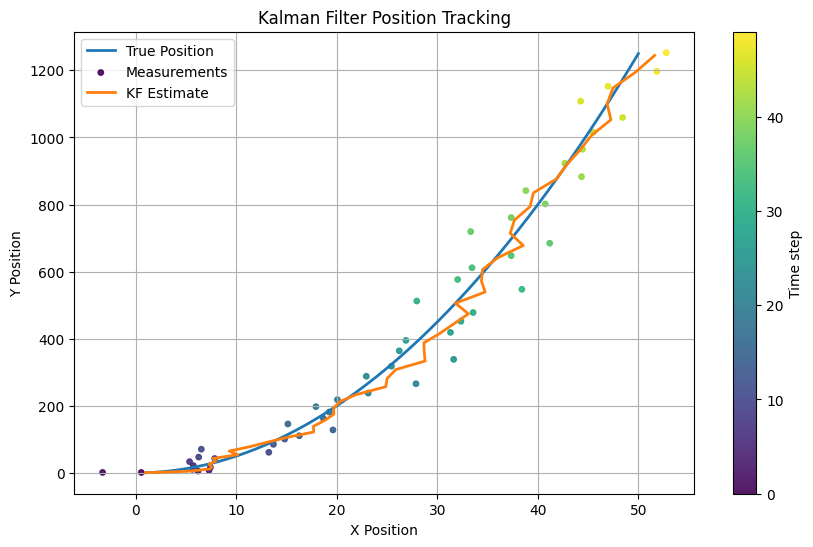

Mean NIS: 10.761942876569428
Expected ~ measurement dim: 2

=== Scenario: Q BASELINE ===


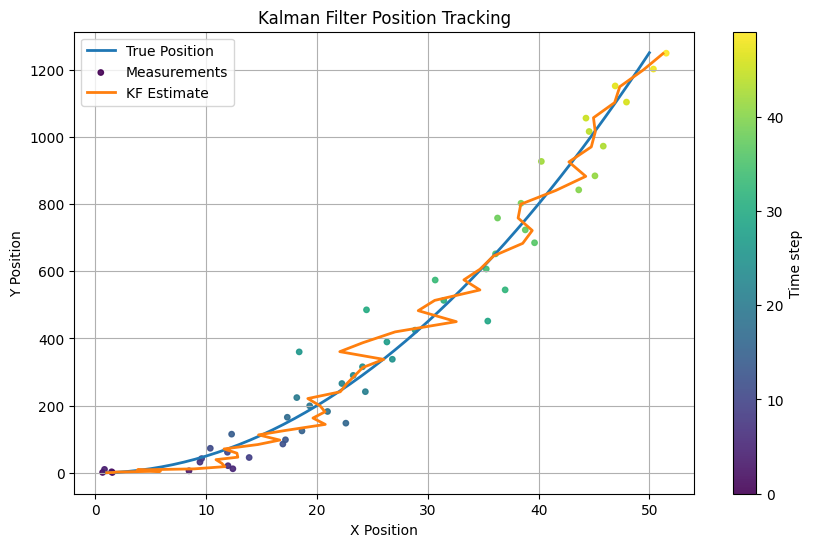

Mean NIS: 2.9114699012333305
Expected ~ measurement dim: 2

=== Scenario: Q HIGH (motion very uncertain) ===


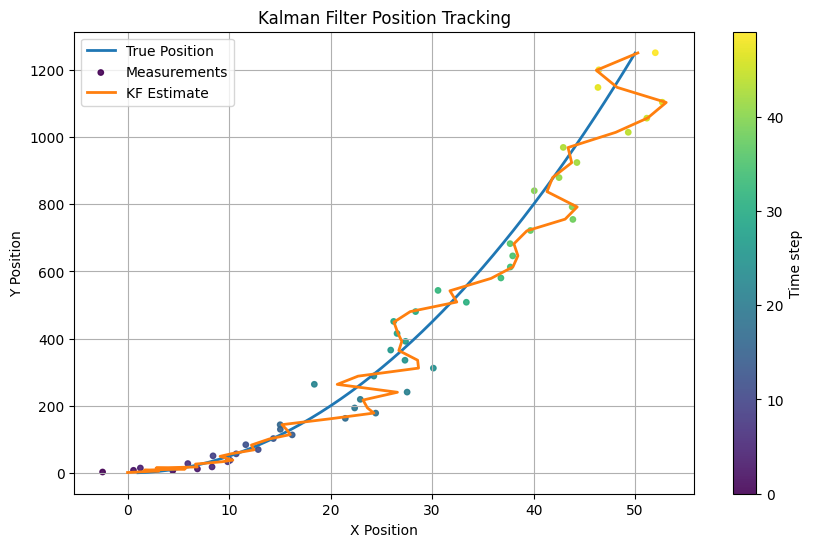

Mean NIS: 1.289081644098208
Expected ~ measurement dim: 2


In [ ]:
Q_low  = 0.1 * Q_base
Q_med  = Q_base
Q_high = 10.0 * Q_base

run_scenario_constant_velocity("Q LOW (trust motion model)",  x0_base, P0_base, F, Q_low,  H, R_base)
run_scenario_constant_velocity("Q BASELINE",                  x0_base, P0_base, F, Q_med,  H, R_base)
run_scenario_constant_velocity("Q HIGH (motion very uncertain)", x0_base, P0_base, F, Q_high, H, R_base)
run_scenario_quadratic("Q LOW (trust motion model)",  x0_base, P0_base, F, Q_low,  H, R_base)
run_scenario_quadratic("Q BASELINE",                  x0_base, P0_base, F, Q_med,  H, R_base)
run_scenario_quadratic("Q HIGH (motion very uncertain)", x0_base, P0_base, F, Q_high, H, R_base)


=== Scenario: P0 SMALL (overconfident start) ===


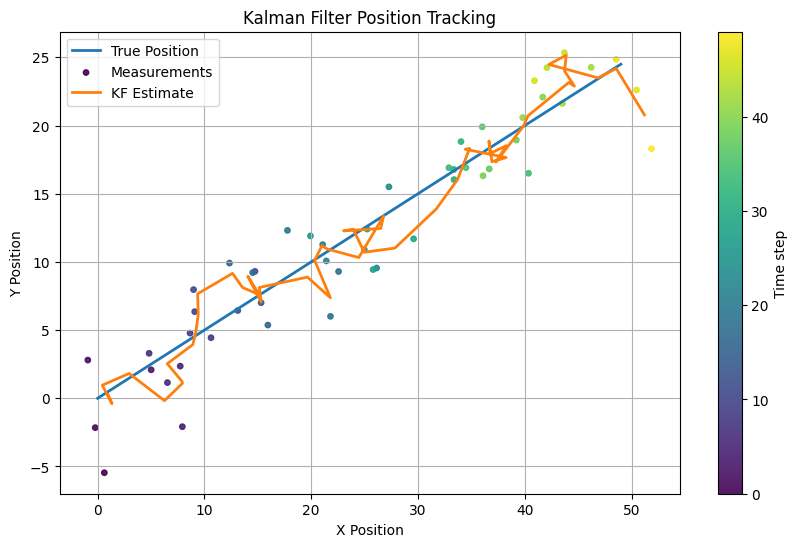

Mean NIS: 1.4562419296059814
Expected ~ measurement dim: 2

=== Scenario: P0 BASELINE ===


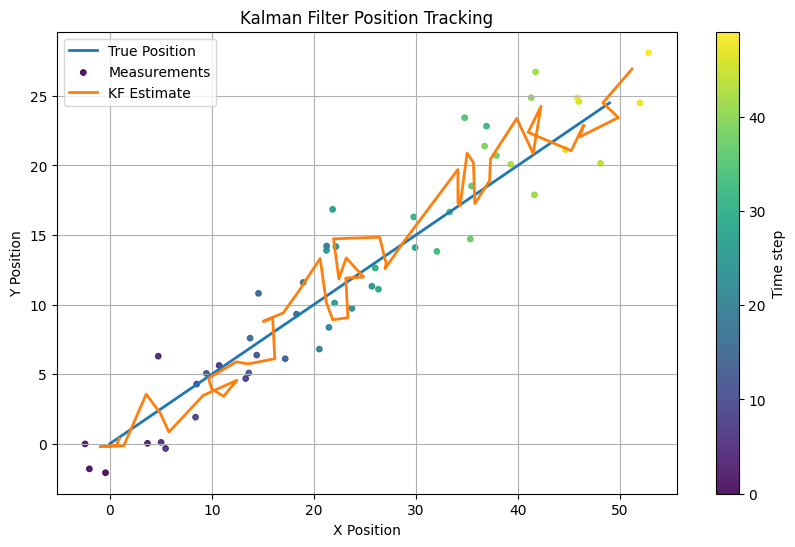

Mean NIS: 1.836684909439978
Expected ~ measurement dim: 2

=== Scenario: P0 LARGE (very uncertain start) ===


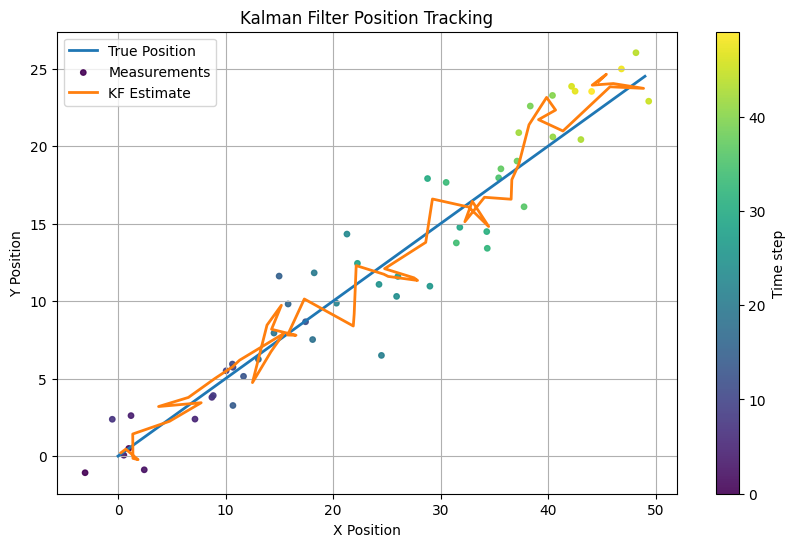

Mean NIS: 1.5582128020047896
Expected ~ measurement dim: 2

=== Scenario: P0 SMALL (overconfident start) ===


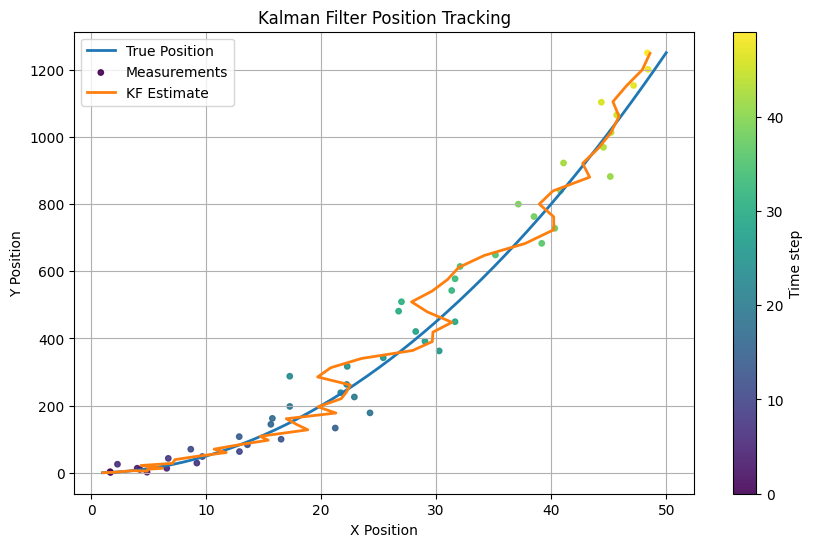

Mean NIS: 2.790072399319864
Expected ~ measurement dim: 2

=== Scenario: P0 BASELINE ===


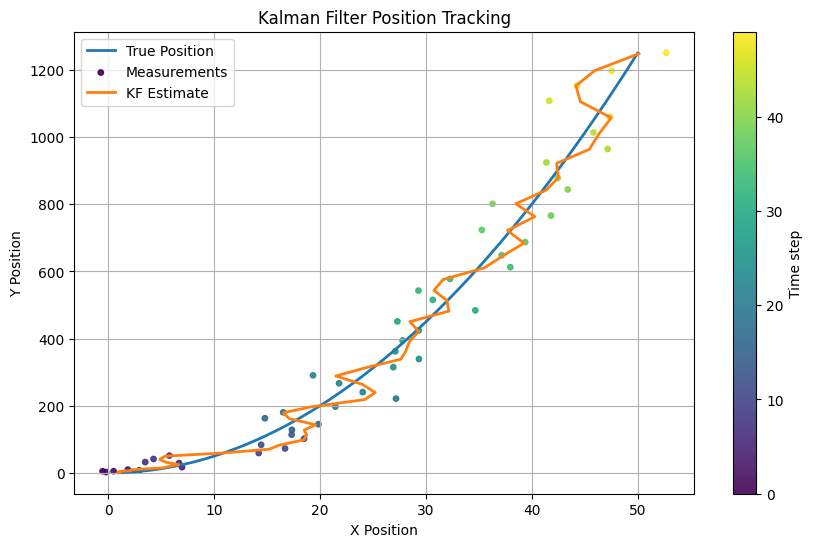

Mean NIS: 2.5881559405572285
Expected ~ measurement dim: 2

=== Scenario: P0 LARGE (very uncertain start) ===


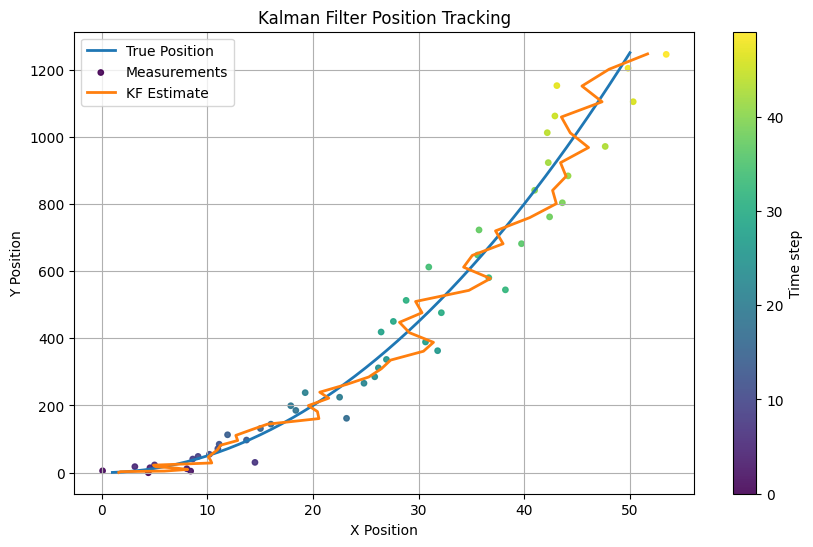

Mean NIS: 2.6175532836614814
Expected ~ measurement dim: 2


In [ ]:
P0_small = 0.1 * P0_base
P0_large = 10.0 * P0_base

run_scenario_constant_velocity("P0 SMALL (overconfident start)", x0_base, P0_small, F, Q_base, H, R_base)
run_scenario_constant_velocity("P0 BASELINE",                    x0_base, P0_base,  F, Q_base, H, R_base)
run_scenario_constant_velocity("P0 LARGE (very uncertain start)",x0_base, P0_large, F, Q_base, H, R_base)
run_scenario_quadratic("P0 SMALL (overconfident start)", x0_base, P0_small, F, Q_base, H, R_base)
run_scenario_quadratic("P0 BASELINE",                    x0_base, P0_base,  F, Q_base, H, R_base)
run_scenario_quadratic("P0 LARGE (very uncertain start)",x0_base, P0_large, F, Q_base, H, R_base)

In [ ]:
def kalman_filter_mismatched_R(true_states, x, P, F, Q, H, R_sim, R_filter):
    x = x.copy()
    P = P.copy()

    true_positions = []
    measurements = []
    estimates = []
    covariances = []

    for k in range(len(true_states)):
        true_state = true_states[k]
        true_pos = H @ true_state

        # Use R_sim to generate noisy measurement
        noise_std = np.sqrt(R_sim[0,0])
        z = true_pos + np.random.normal(0, noise_std, size=2)

        # Standard predict/update, but with R_filter
        x_pred, P_pred = predict(x, P, F, Q)
        x, P = update(x_pred, P_pred, z, H, R_filter)

        true_positions.append(true_pos)
        measurements.append(z)
        estimates.append([x[0], x[2]])
        covariances.append(P)

    return (np.array(true_positions),
            np.array(measurements),
            np.array(estimates),
            np.array(covariances))

In [1]:
true_states = constant_velocity_true_position(50, dt, 1.0, 0.5)

# 1) Actual measurements noisier than we think
R_sim_hi   = 10.0 * R_base    # reality
R_filter_lo = 0.1 * R_base    # overconfident filter

tp, meas, est, cov = kalman_filter_mismatched_R(true_states, x0_base, P0_base,
                                                F, Q_base, H,
                                                R_sim_hi, R_filter_lo)
plot_results(tp, meas, est)

# 2) Actual measurements cleaner than we think
R_sim_lo   = 0.1 * R_base     # reality
R_filter_hi = 10.0 * R_base   # pessimistic filter

tp, meas, est, cov = kalman_filter_mismatched_R(true_states, x0_base, P0_base,
                                                F, Q_base, H,
                                                R_sim_lo, R_filter_hi)
plot_results(tp, meas, est)

NameError: name 'constant_velocity_true_position' is not defined

In [8]:
import pandas as pd

df = pd.read_csv("Data/AIS_2016_11_22.csv")

df = df[[
    "MMSI",
    "BaseDateTime",
    "LAT",
    "LON",
    "SOG",
    "COG"
]]

# Parse timestamps
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

# Pick one vessel (first MMSI)
mmsi = df["MMSI"].iloc[0]
traj = df[df["MMSI"] == mmsi].sort_values("BaseDateTime")

traj = traj.dropna(subset=["LAT", "LON"])

# Full data for filtering
traj_full = traj

# Subsampled data for plotting
traj_plot = traj_full.iloc[::10].copy()

traj.head(), len(traj)

(            MMSI        BaseDateTime       LAT       LON  SOG    COG
 16577  366962010 2016-11-22 00:00:09  29.77390 -95.10135  0.0  278.5
 16579  366962010 2016-11-22 00:01:18  29.77390 -95.10135  0.0  275.3
 16630  366962010 2016-11-22 00:02:28  29.77391 -95.10135  0.1  267.8
 16658  366962010 2016-11-22 00:03:37  29.77391 -95.10135  0.0  278.5
 16723  366962010 2016-11-22 00:04:39  29.77390 -95.10136  0.1  264.2,
 1266)

In [9]:
# Reference position
lat0 = np.deg2rad(traj["LAT"].iloc[0])
lon0 = np.deg2rad(traj["LON"].iloc[0])

R_earth = 6_371_000  # meters

lat = np.deg2rad(traj["LAT"].values)
lon = np.deg2rad(traj["LON"].values)

x = (lon - lon0) * np.cos(lat0) * R_earth
y = (lat - lat0) * R_earth

positions = np.column_stack([x, y])

In [19]:
times = traj["BaseDateTime"].values.astype("datetime64[s]")

dt_array = np.diff(times).astype(float)

# Drop first measurement to align with dt
positions = positions[1:]

dt_array[:10], np.mean(dt_array)

(array([69., 70., 69., 62., 61., 69., 61., 67., 61., 71.]),
 np.float64(68.27588932806324))

In [61]:
# Initial state: [px, vx, py, vy]
x = np.array([
    positions[0, 0],
    0.0,
    positions[0, 1],
    0.0
])

P = np.eye(4) * 10.0

Q = np.eye(4) * 0.1          # process noise
R = np.eye(2) * 25.0         # measurement noise (~5 m GPS)

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

estimates = []
covariances = []

for k in range(len(positions)):
    dt_k = dt[k]

    F = np.array([
        [1, dt_k, 0, 0],
        [0, 1,    0, 0],
        [0, 0,    1, dt_k],
        [0, 0,    0, 1]
    ])

    # Predict
    x, P = predict(x, P, F, Q)

    # Update
    z = positions[k]
    x, P, _, _ = update(x, P, z, H, R)

    estimates.append([x[0], x[2]])
    covariances.append(P)

estimates = np.array(estimates)
covariances = np.array(covariances)

In [62]:
rmse = np.sqrt(np.mean((estimates - positions) ** 2))
rmse

np.float64(0.5606483899027978)

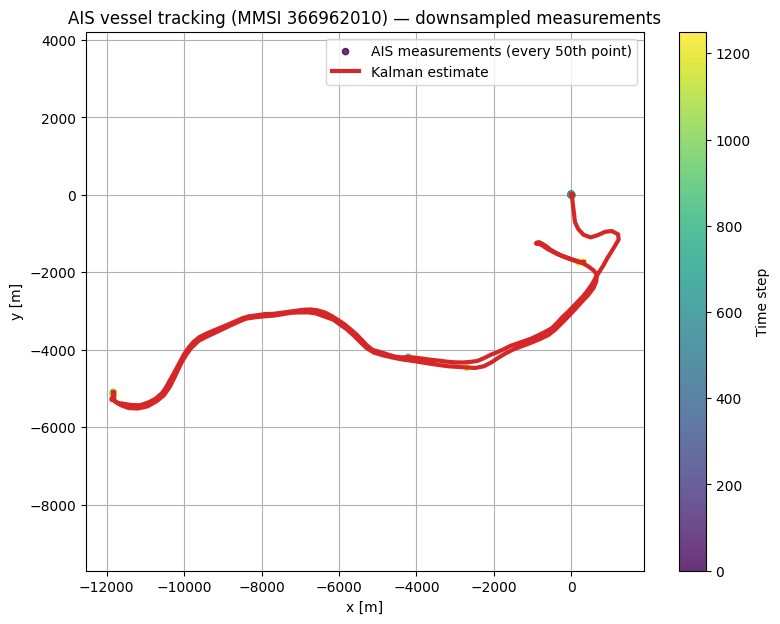

In [68]:
import matplotlib.pyplot as plt
import numpy as np

step = 50
idx_plot = np.arange(0, len(positions), step)

plt.figure(figsize=(9, 7))

# AIS measurements — every 50th point
sc = plt.scatter(
    positions[idx_plot, 0],
    positions[idx_plot, 1],
    c=idx_plot,
    cmap="viridis",
    s=20,
    alpha=0.8,
    label="AIS measurements (every 50th point)",
    zorder=2
)

# Kalman estimate — full resolution
plt.plot(
    estimates[:, 0],
    estimates[:, 1],
    color="tab:red",
    linewidth=3,
    label="Kalman estimate",
    zorder=3
)

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"AIS vessel tracking (MMSI {mmsi}) — downsampled measurements")
plt.axis("equal")
plt.grid(True)
plt.legend()

cbar = plt.colorbar(sc)
cbar.set_label("Time step")

plt.show()

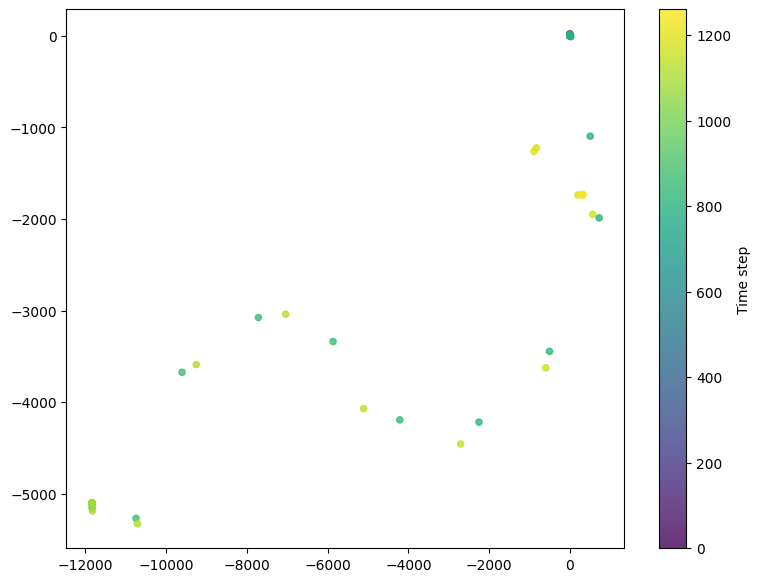

In [70]:
step = 10
idx_plot = np.arange(0, len(positions), step)

plt.figure(figsize=(9, 7))

# AIS measurements — every 50th point
sc = plt.scatter(
    positions[idx_plot, 0],
    positions[idx_plot, 1],
    c=idx_plot,
    cmap="viridis",
    s=20,
    alpha=0.8,
    label="AIS measurements (every 50th point)",
    zorder=2
)
cbar = plt.colorbar(sc)
cbar.set_label("Time step")


pykalman RMSE: 0.6965958009700703


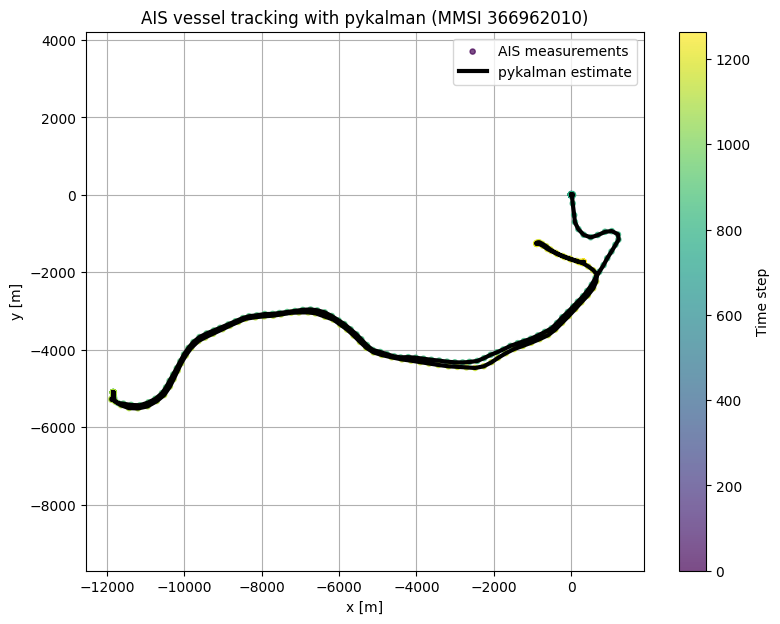

In [71]:
from pykalman import KalmanFilter

# -----------------------------
# Build time-varying transition matrices F_k
# -----------------------------
F_list = []
for dt_k in dt:
    F_list.append(np.array([
        [1, dt_k, 0,     0],
        [0, 1,    0,     0],
        [0, 0,    1, dt_k],
        [0, 0,    0,     1],
    ]))
F_list = np.array(F_list)

# -----------------------------
# Measurement model
# z = [px, py]
# -----------------------------
H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
])

# -----------------------------
# Noise models (same spirit as before)
# -----------------------------
Q = np.eye(4) * 0.1        # process noise
R = np.eye(2) * 25.0       # measurement noise (~5 m std)

# -----------------------------
# Initial state
# -----------------------------
x0 = np.array([
    positions[0, 0],
    0.0,
    positions[0, 1],
    0.0
])
P0 = np.eye(4) * 10.0

# -----------------------------
# Run pykalman
# -----------------------------
kf = KalmanFilter(
    transition_matrices=F_list,
    observation_matrices=H,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0,
)

state_means, state_covs = kf.filter(positions)

# Extract position estimates
estimates_pk = state_means[:, [0, 2]]

# -----------------------------
# RMSE vs measurements (same metric as before)
# -----------------------------
rmse_pk = np.sqrt(np.mean((estimates_pk - positions) ** 2))
print("pykalman RMSE:", rmse_pk)

# -----------------------------
# Plot: points + pykalman estimate
# -----------------------------
t_idx = np.arange(len(positions))

plt.figure(figsize=(9, 7))

plt.scatter(
    positions[:, 0],
    positions[:, 1],
    c=t_idx,
    cmap="viridis",
    s=14,
    alpha=0.7,
    label="AIS measurements",
    zorder=2
)

plt.plot(
    estimates_pk[:, 0],
    estimates_pk[:, 1],
    color="black",
    linewidth=3,
    label="pykalman estimate",
    zorder=3
)

plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"AIS vessel tracking with pykalman (MMSI {mmsi})")
plt.axis("equal")
plt.grid(True)
plt.legend()

cbar = plt.colorbar()
cbar.set_label("Time step")

plt.show()

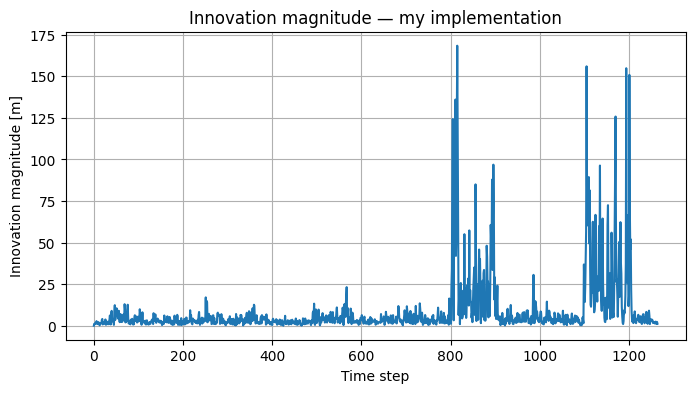

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Measurement model
H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

Q = np.eye(4) * 0.1
R = np.eye(2) * 25.0

# Initial state
x = np.array([
    positions[0, 0],
    0.0,
    positions[0, 1],
    0.0
])
P = np.eye(4) * 10.0

innovations = []

for k in range(len(positions)):
    dt_k = dt[k]

    F = np.array([
        [1, dt_k, 0, 0],
        [0, 1,    0, 0],
        [0, 0,    1, dt_k],
        [0, 0,    0, 1]
    ])

    # Predict
    x_pred, P_pred = predict(x, P, F, Q)

    # Innovation (measurement residual)
    z = positions[k]
    y = z - H @ x_pred
    innovations.append(y)

    # Update
    x, P, _, _ = update(x_pred, P_pred, z, H, R)

innovations = np.array(innovations)

# Plot innovation magnitude
plt.figure(figsize=(8, 4))
plt.plot(np.linalg.norm(innovations, axis=1))
plt.xlabel("Time step")
plt.ylabel("Innovation magnitude [m]")
plt.title("Innovation magnitude — my implementation")
plt.grid(True)
plt.show()

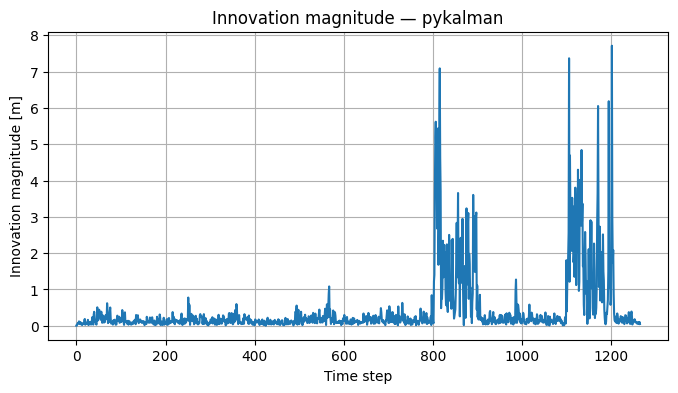

In [73]:
from pykalman import KalmanFilter

# Build time-varying transition matrices
F_list = []
for dt_k in dt:
    F_list.append(np.array([
        [1, dt_k, 0, 0],
        [0, 1,    0, 0],
        [0, 0,    1, dt_k],
        [0, 0,    0, 1]
    ]))
F_list = np.array(F_list)

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

Q = np.eye(4) * 0.1
R = np.eye(2) * 25.0

x0 = np.array([
    positions[0, 0],
    0.0,
    positions[0, 1],
    0.0
])
P0 = np.eye(4) * 10.0

kf = KalmanFilter(
    transition_matrices=F_list,
    observation_matrices=H,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0
)

# Run filter
state_means, _ = kf.filter(positions)

# Compute innovations explicitly
innovations_pk = []
for k in range(len(positions)):
    z_pred = H @ state_means[k]
    innovations_pk.append(positions[k] - z_pred)

innovations_pk = np.array(innovations_pk)

# Plot innovation magnitude
plt.figure(figsize=(8, 4))
plt.plot(np.linalg.norm(innovations_pk, axis=1))
plt.xlabel("Time step")
plt.ylabel("Innovation magnitude [m]")
plt.title("Innovation magnitude — pykalman")
plt.grid(True)
plt.show()

Going to now downsample my AIS data to see how my Kalman implementation behaves.

Need to compute F and Q as dt isn't fixed in my AIS data, and this will only exacerbate my predictions in between measurements.

In [1]:
def compute_F(dt):
    return np.array([
        [1, dt, 0, 0],
        [0, 1, 0, 0], 
        [0, 0, 1, dt],
        [0, 0, 0, 1]
    ])

In [2]:
def compute_Q(dt, sigma_a):
    dt2 = dt**2
    dt3 = dt**3
    dt4 = dt**4

    q = np.array([
        [dt4/4, dt3/2, 0,      0],
        [dt3/2, dt2,   0,      0],
        [0,      0,    dt4/4, dt3/2],
        [0,      0,    dt3/2, dt2]
    ])

    return sigma_a**2 * q

In [16]:
def kalman_filter_downsample(
    positions,
    dt_array,
    x,
    P,
    R,
    sigma_a,
    downsample_factor=5
):
    x = x.copy()
    P = P.copy()

    
    estimates = []

    for k in range(len(positions)):

        z = positions[k]

        # Compute dt
        if k == 0:
            dt_k = dt_array[0]
        else:
            dt_k = dt_array[k]

        # Recompute model matrices
        F = compute_F(dt_k)
        Q = compute_Q(dt_k, sigma_a)

        # Predict
        x_pred, P_pred = predict(x, P, F, Q)

        # Update only every N steps
        if k % downsample_factor == 0:
            x, P, _, _ = update(x_pred, P_pred, z, H, R)
        else:
            x = x_pred
            P = P_pred

        estimates.append([x[0], x[2]])

    return np.array(estimates)

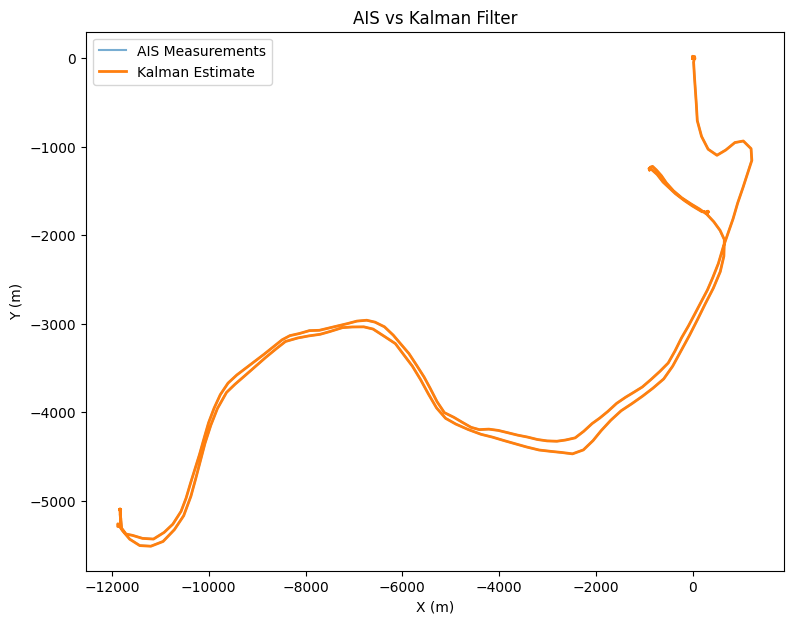

In [22]:
R = np.eye(2) * 25.0

estimates = kalman_filter_downsample(
    positions,
    dt_array,
    x,
    P,
    R,
    sigma_a=0.01,
    downsample_factor=1
)

plt.figure(figsize=(9,7))

plt.plot(positions[:,0], positions[:,1],
         label="AIS Measurements", alpha=0.6)

plt.plot(estimates[:,0], estimates[:,1],
         label="Kalman Estimate", linewidth=2)

plt.legend()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("AIS vs Kalman Filter")
plt.show()

In [23]:
rmse = np.sqrt(np.mean((estimates - positions)**2))
print("RMSE:", rmse)

RMSE: 0.37687727136276983


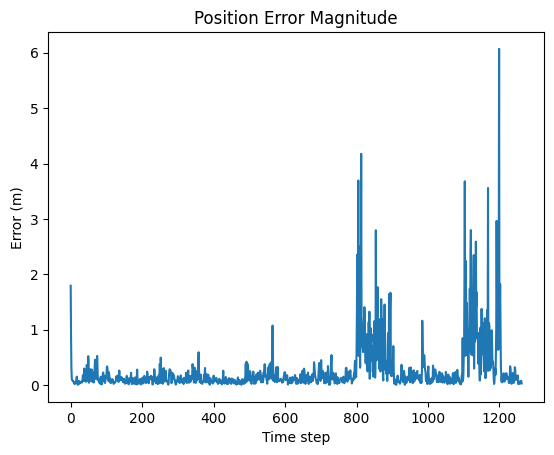

In [24]:
error = np.linalg.norm(estimates - positions, axis=1)

plt.plot(error)
plt.title("Position Error Magnitude")
plt.ylabel("Error (m)")
plt.xlabel("Time step")
plt.show()